In [ ]:
# Computing the uncertainty of a segmentation model like UNet can be done using Monte Carlo Dropout (MC Dropout). MC Dropout is a technique where dropout is applied during both training and testing, and multiple forward passes are made to compute the uncertainty.

# Here's a step-by-step guide:

# Train your UNet model with dropout layers. Dropout layers are typically added after each convolutional layer.

# During prediction, enable dropout at test time. This can be done by setting the model to training mode.

# Pass the image through the model multiple times (e.g., 100 times). Each pass will generate a different prediction due to the dropout.

# Calculate the mean and variance (or standard deviation) of the predictions. The variance or standard deviation can be used as a measure of uncertainty.


# The mean and variance obtained from the predict_with_uncertainty function represent the model's predictions and their uncertainty at each pixel. If you want to get an overall value of uncertainty for the entire image, you can calculate the mean of the variance. This will give you an average measure of uncertainty across all pixels in the image.

# Yes, you're correct. The Monte Carlo Dropout method for estimating uncertainty requires dropout layers in the model. If there are no dropout layers, the model's predictions will be deterministic, leading to zero variance and hence zero uncertainty.

# he dropout layers introduce randomness into the model's predictions, which is what allows Monte Carlo Dropout to estimate uncertainty.

# When you load a model trained without dropout layers and then add dropout layers, the weights of the dropout layers are not trained, so they don't contribute to the model's predictions and hence don't introduce any randomness.


# Dropout is a regularization technique used in neural networks to prevent overfitting. During training, dropout randomly "drops out" (i.e., sets to zero) a number of output features of the layer during each forward pass. The "dropout rate" is the fraction of the features that are zeroed out; it's usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, to balance for the fact that more units are active than at training time.

# This makes the output of a layer with dropout effectively a random sample from a distribution over possible outputs, which introduces randomness into the model's predictions. This is why dropout makes the model's predictions non-deterministic.

# In the context of U-Net, dropout can help to prevent overfitting, especially given that U-Net has a large number of parameters due to its symmetric expansive path. However, dropout can also cause information loss along the network's skip connections, which are crucial for U-Net's performance.

# Monte Carlo Dropout is a technique to estimate the model's uncertainty. The idea is to perform multiple forward passes with dropout enabled during testing, and then average the results. Each forward pass will produce different results due to the randomness introduced by dropout, and the variance of these results can be used as an estimate of the model's uncertainty. This can be particularly useful in tasks like segmentation, where it's important to know which parts of the image the model is uncertain about.




# Regularization is a technique used in machine learning to prevent overfitting, which is a situation where a model performs well on the training data but poorly on unseen data (like validation or test data). Overfitting typically occurs when the model is too complex, such as having too many parameters relative to the number of observations. The model learns the noise in the training data, which negatively impacts its ability to generalize to new data.

# Regularization works by adding a penalty to the loss function that the model optimizes. This penalty discourages the model from learning overly complex patterns in the training data, helping it to generalize better to new data.

# There are several types of regularization techniques:

# L1 and L2 regularization: These add a penalty proportional to the absolute value (L1) or square (L2) of the model parameters to the loss function. This encourages the model to keep its parameters small.

# Dropout: This randomly sets a fraction of the input units to 0 at each update during training time, which helps prevent overfitting.

# Early stopping: In this form of regularization, we stop training as soon as the validation error reaches a minimum. As we keep on training, the model will start to overfit, so stopping early helps to prevent that.

# Data augmentation: This technique generates new training samples by applying transformations (like rotation, scaling, etc.) to the existing data. This can help to increase the size of the training set and reduce overfitting.

# Batch normalization: This technique normalizes the inputs of each layer in such a way that they have a mean output activation of zero and standard deviation of one. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

# These techniques help to make the model more robust and improve its performance on unseen data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from utils.dl.prediction import predict_with_uncertainty
from utils.dl.model import MCDUNet
import torch
from utils.dl.niab import IMG_TRANSFORMS
from utils.image_utils import load_image_ts, reduce_resolution, white_balance
from PIL import Image
import cv2

In [3]:
# Load uncertainties from csv file
df = pd.read_csv('../uncertainty_2.csv')

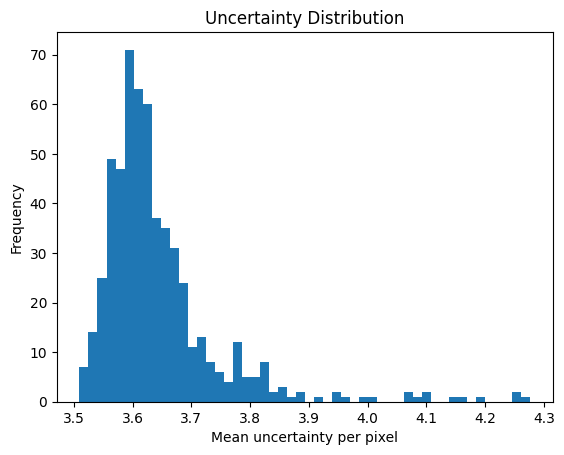

In [4]:
# Plot histogram of uncertainties
plt.hist(df['mean_uncertainty'], bins=50)
plt.xlabel('Mean uncertainty per pixel')
plt.ylabel('Frequency')
plt.title('Uncertainty Distribution')
plt.show()

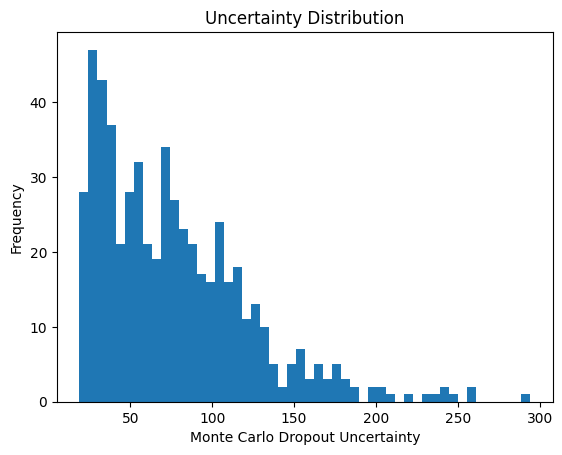

In [5]:
# Plot histogram of uncertainties
plt.hist(df['mcd_uncertainty'], bins=50)
plt.xlabel('Monte Carlo Dropout Uncertainty')
plt.ylabel('Frequency')
plt.title('Uncertainty Distribution')
plt.show()

In [6]:
# Get the 10 images with the highest uncertainty
top10 = df.nlargest(10, 'mcd_uncertainty')

# print the top 10 images with highest uncertainty
print(top10)

                                              img_path  mean_uncertainty  \
11   ./datasets/niab/EXP01/Top_Images/Top_Images_Cl...          3.675112   
10   ./datasets/niab/EXP01/Top_Images/Top_Images_Cl...          3.829175   
12   ./datasets/niab/EXP01/Top_Images/Top_Images_Cl...          3.740194   
18   ./datasets/niab/EXP01/Top_Images/Top_Images_Cl...          3.683908   
17   ./datasets/niab/EXP01/Top_Images/Top_Images_Cl...          3.611821   
29   ./datasets/niab/EXP01/Top_Images/Top_Images_Cl...          3.651080   
25   ./datasets/niab/EXP01/Top_Images/Top_Images_Cl...          3.624247   
549  ./datasets/niab/EXP01/Top_Images/Top_Images_Cl...          3.611199   
5    ./datasets/niab/EXP01/Top_Images/Top_Images_Cl...          3.581389   
28   ./datasets/niab/EXP01/Top_Images/Top_Images_Cl...          3.732139   

     mcd_uncertainty  
11        294.251678  
10        257.363190  
12        256.272797  
18        247.473618  
17        242.497574  
29        240.167984  
25

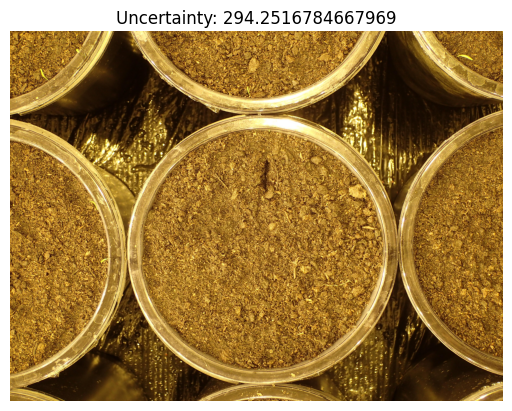

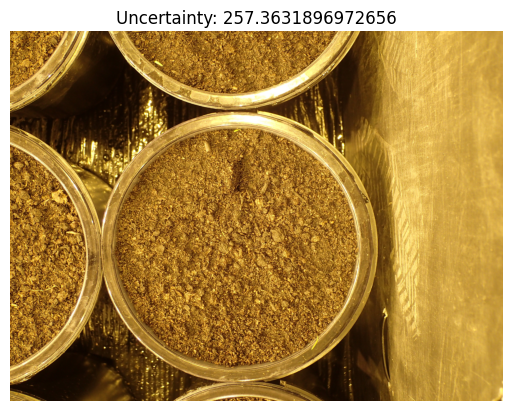

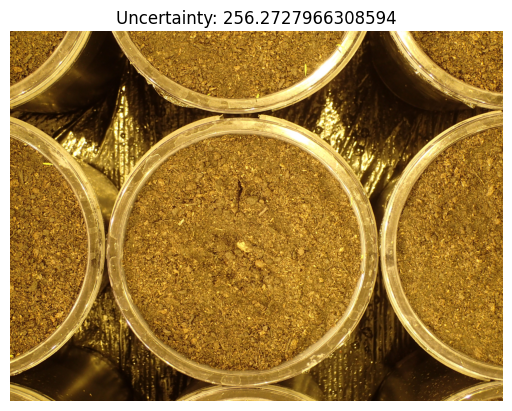

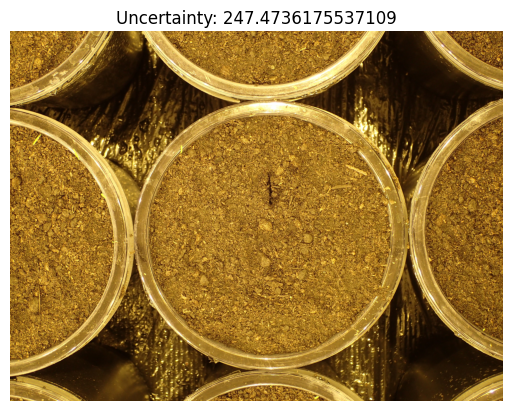

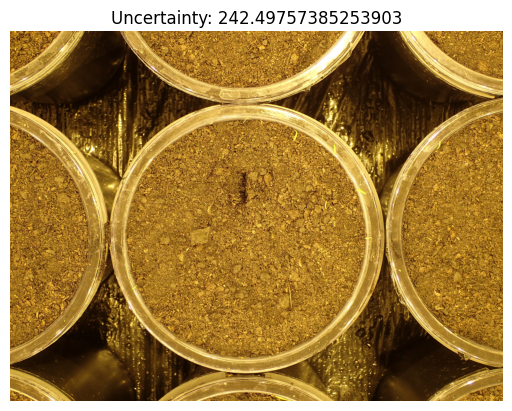

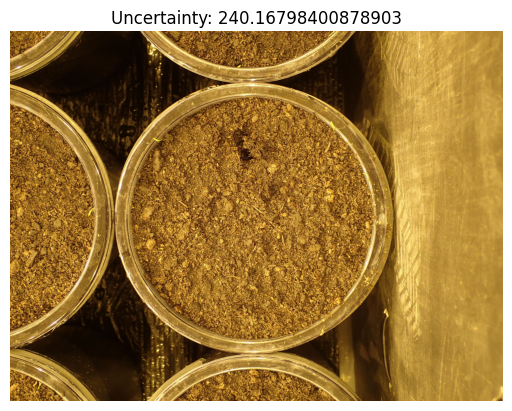

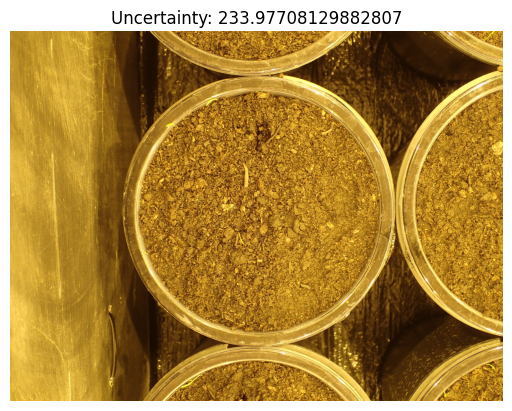

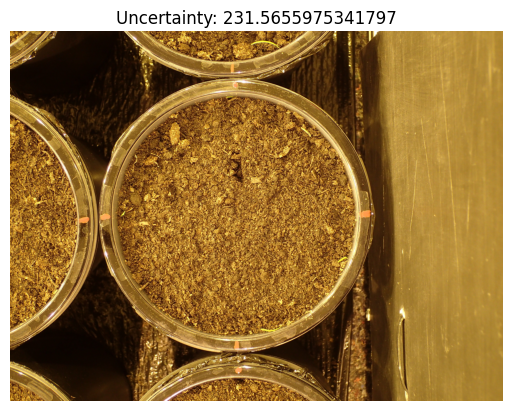

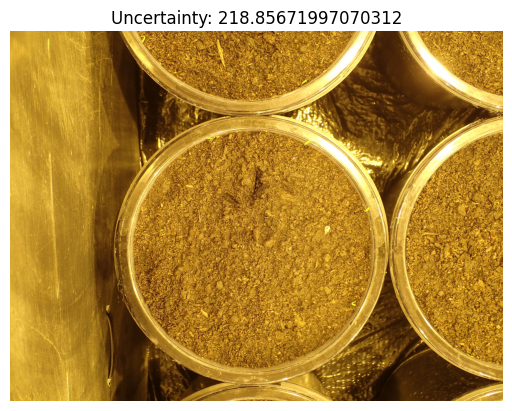

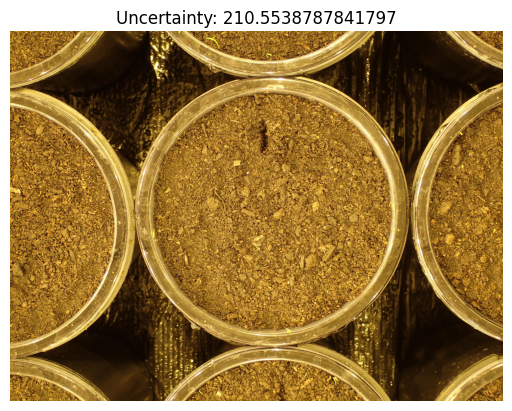

In [7]:
# display the top 10 images with highest uncertainty

for index, row in top10.iterrows():
    image_path = row['img_path']
    image_path = os.path.join('..', image_path)
    uncertainty = row['mcd_uncertainty']
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title(f'Uncertainty: {uncertainty}')
    plt.axis('off')
    plt.show()

Running model using cuda device


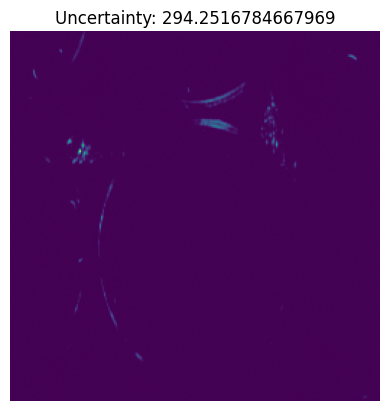

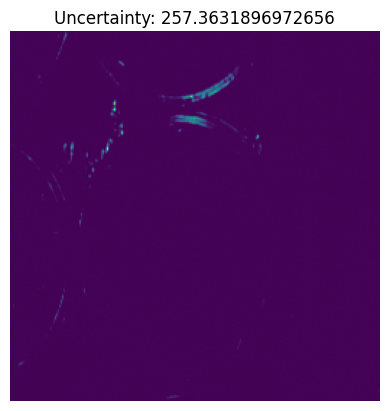

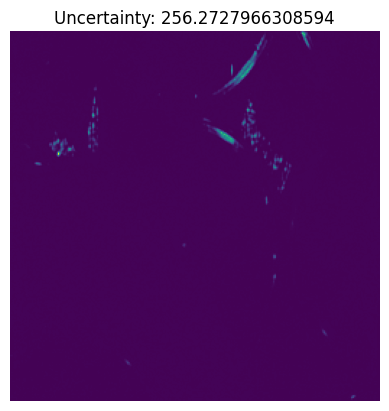

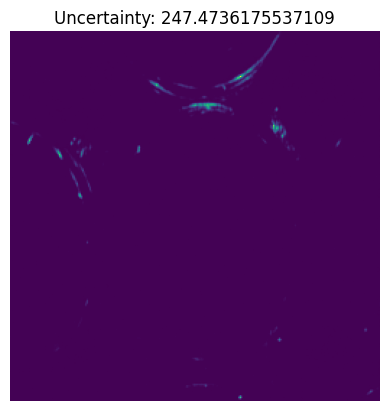

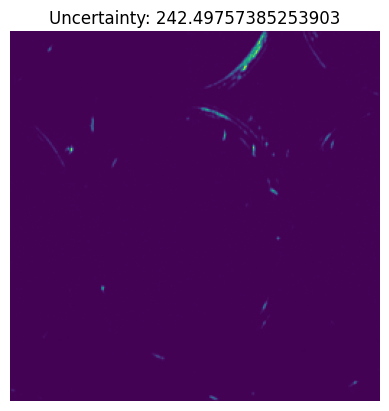

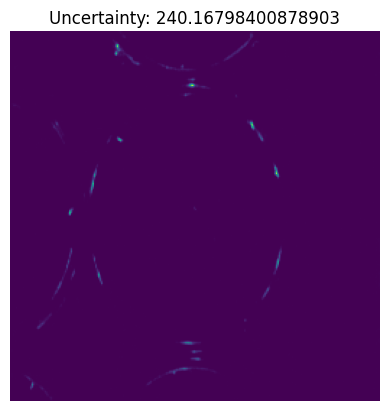

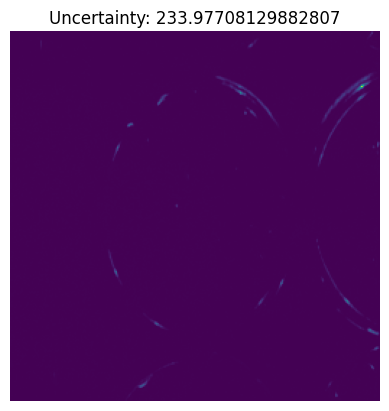

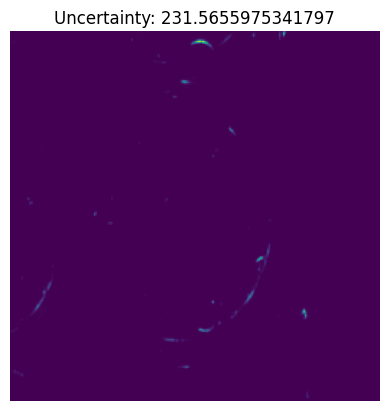

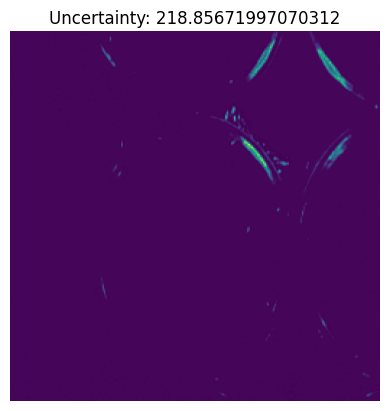

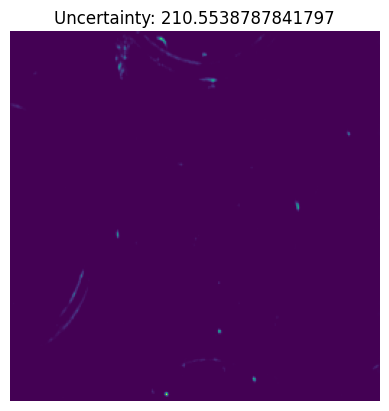

In [11]:

MODEL_PATH = "../models/20240514122226/best_model.pth"

device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running model using {device} device")

# Create an instance of the model and move it to the device (GPU or CPU)
model = MCDUNet(n_channels=3,
             n_classes=1,
             bilinear=True,
             ddims=[32, 64, 128, 256, 512],
             UQ=True,
             ).to(device)

model.load_state_dict(torch.load(MODEL_PATH))

# load and parse image to predict with uncertay function and plot the uncertaity matrix / image for the top 10 images
for index, row in top10.iterrows():
    image_path = row['img_path']
    image_path = os.path.join('..', image_path)
    uncertainty = row['mcd_uncertainty']
    img = white_balance(cv2.imread(image_path))
    img = Image.fromarray(img)
    img = IMG_TRANSFORMS(img)
    mean, variance = predict_with_uncertainty(model, img, device)
    uncertainty_image = variance
    # move to cpu and convert to numpy
    uncertainty_image = uncertainty_image.squeeze().cpu().detach().numpy()
    plt.imshow(uncertainty_image)
    plt.title(f'Uncertainty: {uncertainty}')
    plt.axis('off')
    plt.show()